![tile](DadosAoCubo.png)

# Análise de Dados: Detecção de Fraude de Cartão de Crédito

Criado por [Jaqueline Lopes](https://github.com/JaquelineLD)

## Conjunto de Dados

**Dataset Credit Card Fraud Detection**: https://www.kaggle.com/mlg-ulb/creditcardfraud

Queremos analisar os dados de transações de clientes titulares coletados durante 2 dias no mês de setembro/2013. Temos um total de 284.807 transações, sendo que apenas 0,173% (492) transações foram fraude. Seguindo as regulamentações estabelecidas pela GDPR, a maioria das observações são resultado de uma transformação PCA. Apenas o tempo e a quantia gasta, estão disponíveis, além das classificação da transação fraude (1) e não fraude (0).

### Bibliotecas Utilizadas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as miss
import joblib
from scipy import stats
from collections import Counter
import matplotlib.pyplot as plt
import itertools
from sklearn import tree
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn import model_selection
from sklearn import feature_selection
from sklearn.metrics import precision_recall_curve
from time import perf_counter 


import warnings
warnings.filterwarnings('ignore')

## Leitura dos Dados

Utilizamos a biblioteca pandas para importar os nossos dados:

In [32]:
dados = pd.read_csv('creditcard.csv', index_col=None)

Verificamos se os dados foram importados corretamente de acordo com o esperado:

In [3]:
dados.shape

(284807, 31)

In [4]:
classe = dados.values[:,-1]
counter = Counter(classe) 
for c1, c2 in counter.items():
    c3 = c2 / len(classe) * 100
    print('Classe=%d, Contagem=%d, Porcentagem=%.3f%%' % (c1, c2, c3))

Classe=0, Contagem=284315, Porcentagem=99.827%
Classe=1, Contagem=492, Porcentagem=0.173%


In [52]:
dados.head(100)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,Amount_log,Time_min
0,94814.525391,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0,5.008099,20
1,94814.525391,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0,0.989541,20
2,1.000000,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0,5.936639,0
3,1.000000,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0,4.816241,0
4,2.000000,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0,4.248352,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,64.000000,-0.658305,0.406791,2.037461,-0.291298,0.147910,-0.350857,0.945373,-0.172560,0.025133,...,0.089877,0.421195,-0.352487,0.074783,-0.094192,-0.092493,54.99,0.0,4.007151,1
96,64.000000,0.959602,0.370711,0.888613,2.343244,0.352491,1.365515,-0.277771,0.516053,-0.700929,...,0.356504,-0.696881,-0.198718,-0.220268,0.068546,0.020797,7.55,0.0,2.021548,1
97,67.000000,-0.653445,0.160225,1.592256,1.296832,0.997175,-0.343000,0.469937,-0.132470,-0.197794,...,-0.014883,0.102959,-0.265322,-0.348637,0.011238,-0.049478,19.85,0.0,2.988204,1
98,67.000000,-1.494668,0.837241,2.628211,3.145414,-0.609098,0.258495,-0.012189,0.102136,-0.286164,...,0.332720,0.718193,-0.219366,0.118927,-0.317486,-0.340783,28.28,0.0,3.342155,1


In [7]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [8]:
names = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class']

In [9]:
# número de dados ausentes em cada coluna
dados.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [10]:
# contar linhas zeradas
dados.isin([0]).sum()

Time           2
V1             0
V2             0
V3             0
V4             0
V5             0
V6             0
V7             0
V8             0
V9             0
V10            0
V11            0
V12            0
V13            0
V14            0
V15            0
V16            0
V17            0
V18            0
V19            0
V20            0
V21            0
V22            0
V23            0
V24            0
V25            0
V26            0
V27            0
V28            0
Amount      1825
Class     284315
dtype: int64

## Tratamendo do Dados

Foram identificados valores nulos nas variáveis 'Time' (2) e 'Amount' (1825). Como se trata de transações no cartão de crédito, não faz sentido ter 'Amount' zero. Como não tenho orientação da área de negócio sobre como lidar com essas informaçãoes, optei por substituir esses valores pela média.

In [33]:
dados.loc[dados["Time"] == 0.0, "Time"] = np.NAN
dados.loc[dados["Amount"] == 0.0, "Amount"] = np.NAN
dados.isnull().sum()[['Time', 'Amount']]

Time         2
Amount    1825
dtype: int64

In [34]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(dados)
dados_missmean = imputer.transform(dados)
dados_mean = pd.DataFrame(dados_missmean, columns=names)

In [35]:
dados_mean[["Time","Amount"]].describe()

,Time,Amount
count,284807.000000,284807.000000
mean,94814.525391,88.919401
std,47487.481270,250.019457
min,1.000000,0.010000
25%,54203.000000,5.990000
50%,84694.000000,22.900000
75%,139320.500000,79.900000
max,172792.000000,25691.160000


In [36]:
dados = dados_mean

## Análise Exploratória

Estamos à procura de evidências que auxiliem na construção do nosso modelo e insights relevantes para o negócio.

In [37]:
dados[["Time","Amount","Class"]].describe()

,Time,Amount,Class
count,284807.000000,284807.000000,284807.000000
mean,94814.525391,88.919401,0.001727
std,47487.481270,250.019457,0.041527
min,1.000000,0.010000,0.000000
25%,54203.000000,5.990000,0.000000
50%,84694.000000,22.900000,0.000000
75%,139320.500000,79.900000,0.000000
max,172792.000000,25691.160000,1.000000


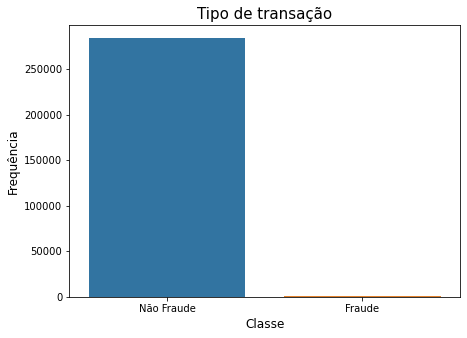

In [57]:
heigths = [284315,492]
bars_name = ('Não Fraude','Fraude')
y_pos = np.arange(len(bars_name))


plt.figure(figsize=(7,5))
sns.countplot(dados['Class'])
plt.xticks(y_pos,bars_name)
plt.title("Tipo de transação", fontsize=15)
plt.xlabel("Classe", fontsize=12)
plt.ylabel("Frequência", fontsize=12)
plt.show()

### Valor da transação (amount)

In [40]:
# Resumo estatístico
fraude = dados[dados['Class'] == 1]
normal = dados[dados['Class'] == 0]

print("Fraude - resumo estatístico")
print(fraude["Amount"].describe())
print("\nNão Fraude - resumo estatístico")
print(normal["Amount"].describe())

Fraude - resumo estatístico
count     492.000000
mean      127.091044
std       255.151116
min         0.010000
25%         1.000000
50%        22.915000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Não Fraude - resumo estatístico
count    284315.000000
mean         88.853346
std         250.005892
min           0.010000
25%           5.990000
50%          22.900000
75%          79.850000
max       25691.160000
Name: Amount, dtype: float64


Fraude x Amount (valor)

Text(0, 0.5, 'Amount(Log)')

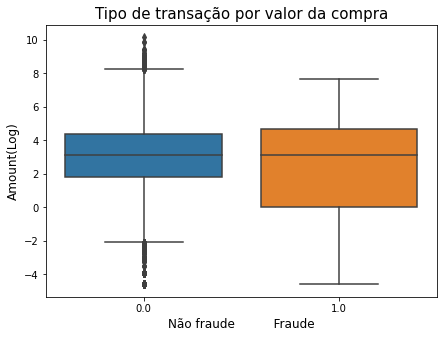

In [59]:
dados['Amount_log'] = np.log(dados.Amount)
plt.figure(figsize=(7,5))
ax1 = sns.boxplot(x ="Class",y="Amount_log", data=dados)
ax1.set_title("Tipo de transação por valor da compra", fontsize=15)
ax1.set_xlabel("Não fraude          Fraude", fontsize=12)
ax1.set_ylabel("Amount(Log)", fontsize = 12)

Aplicação da transformação logarítmica para reduzir o efeito de vieses dos dados, como outliers.

### Tempo

Refere-se ao tempo decorrido entre a realização da transação e o registro no banco de dados.

In [42]:
timedelta = pd.to_timedelta(dados['Time'], unit='s')
dados['Time_min'] = (timedelta.dt.components.minutes).astype(int)

In [53]:
fraude = dados[dados['Class'] == 1]
normal = dados[dados['Class'] == 0]

print("Fraude - resumo estatístico")
print(fraude["Time_min"].describe())
print("\nNão Fraude - resumo estatístico")
print(normal["Time_min"].describe())

Fraude - resumo estatístico
count    492.000000
mean      28.945122
std       17.327534
min        0.000000
25%       14.000000
50%       28.000000
75%       42.250000
max       59.000000
Name: Time_min, dtype: float64

Não Fraude - resumo estatístico
count    284315.000000
mean         28.997274
std          17.427899
min           0.000000
25%          14.000000
50%          29.000000
75%          44.000000
max          59.000000
Name: Time_min, dtype: float64


Text(0, 0.5, 'Tempo de registro (minutos)')

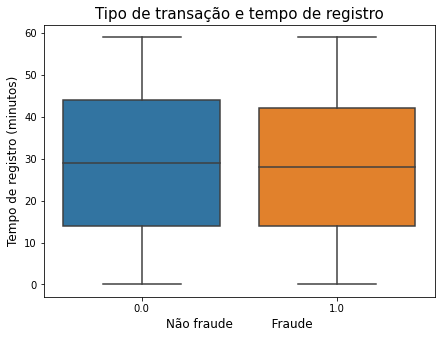

In [55]:
plt.figure(figsize=(7,5))
ax1 = sns.boxplot(x ="Class",y="Time_min", data=dados)
ax1.set_title("Tipo de transação e tempo de registro", fontsize=15)
plt.xlabel("Não fraude          Fraude", fontsize=12)
ax1.set_ylabel("Tempo de registro (minutos)", fontsize = 12)

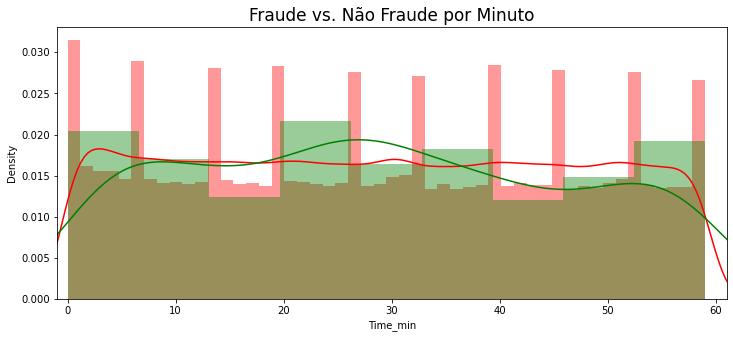

In [62]:
plt.figure(figsize=(12,5))
sns.distplot(dados[dados['Class'] == 0]["Time_min"], 
             color='r')
sns.distplot(dados[dados['Class'] == 1]["Time_min"], 
             color='g')
plt.title('Fraude vs. Não Fraude por Minuto', fontsize=17)
plt.xlim([-1,61])
plt.show()

Não vemos uma diferenciação entre padrões de fraude e não fraude.

## Seleção de Atributos

Modelos baseados em árvores nos ajuda a verificar a importância dos atributos. Uma importância maior normalemnete indica que há maior erro qaundo a variável é removida do modelo.

In [64]:
X, y = dados.values[:, 0:30], dados.values[:, 30]

In [65]:
model = XGBClassifier()
model.fit(X, y)

[14:14:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [66]:
importancia = model.feature_importances_

Atributo: 0, Score: 0.011
Atributo: 1, Score: 0.012
Atributo: 2, Score: 0.012
Atributo: 3, Score: 0.013
Atributo: 4, Score: 0.014
Atributo: 5, Score: 0.014
Atributo: 6, Score: 0.015
Atributo: 7, Score: 0.015
Atributo: 8, Score: 0.015
Atributo: 9, Score: 0.015
Atributo: 10, Score: 0.016
Atributo: 11, Score: 0.016
Atributo: 12, Score: 0.017
Atributo: 13, Score: 0.018
Atributo: 14, Score: 0.018
Atributo: 15, Score: 0.018
Atributo: 16, Score: 0.019
Atributo: 17, Score: 0.020
Atributo: 18, Score: 0.020
Atributo: 19, Score: 0.020
Atributo: 20, Score: 0.021
Atributo: 21, Score: 0.023
Atributo: 22, Score: 0.023
Atributo: 23, Score: 0.026
Atributo: 24, Score: 0.027
Atributo: 25, Score: 0.028
Atributo: 26, Score: 0.034
Atributo: 27, Score: 0.052
Atributo: 28, Score: 0.062
Atributo: 29, Score: 0.383


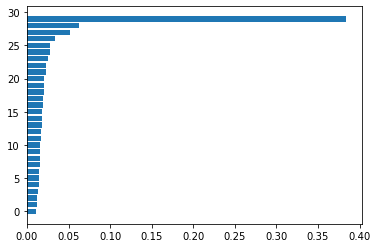

In [71]:
for i,v in enumerate(importancia):
    print('Atributo: %0d, Score: %.3f' % (i,v))
plt.barh([x for x in range(len(importancia))], importancia)
plt.show()

## Construção do modelo

Observe que as variáveis que não foram aplicadas a transformação PCA estão em escala diferentes. Trazemos todos para a mesma escala, assim podemos utilizar algorimos sensíveis a escala dos dados. Normalização dos dados, vamos trazer os dados para a mesma escala.

In [73]:
X = scale(X)

Cross-Validation para Classes Desbalanceadas

In [74]:
cv = StratifiedKFold(n_splits=10)
# verificando as amostras
for train_ix, test_ix in cv.split(X, y):
    # linhas
    train_X, test_X = X[train_ix], X[test_ix]
    train_y, test_y = y[train_ix], y[test_ix]
    # resumo das amostras
    train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
    print('>Treino: 0=%d, 1=%d, Teste: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

>Treino: 0=255883, 1=443, Teste: 0=28432, 1=49
>Treino: 0=255883, 1=443, Teste: 0=28432, 1=49
>Treino: 0=255883, 1=443, Teste: 0=28432, 1=49
>Treino: 0=255883, 1=443, Teste: 0=28432, 1=49
>Treino: 0=255883, 1=443, Teste: 0=28432, 1=49
>Treino: 0=255884, 1=442, Teste: 0=28431, 1=50
>Treino: 0=255884, 1=442, Teste: 0=28431, 1=50
>Treino: 0=255884, 1=443, Teste: 0=28431, 1=49
>Treino: 0=255884, 1=443, Teste: 0=28431, 1=49
>Treino: 0=255884, 1=443, Teste: 0=28431, 1=49


Função para avaliar os modelos

In [75]:
def avaliar_modelo(models, X, y):

    colors = ['m','k','g','b','r','c','y']
# Criação de uma tabela com as métricas de avaliação do modelo.

    tabela_medias = {
        'ROC AUC': [],
        'AUPRC': [],
        'Precision': [],
        'Recall': [],
        'Time': [],
    }

# Criação da figura que compara duas curvas de avaliação do modelo
    fig, (ax_roc, ax_precrecall) = plt.subplots(1, 2)
    for model_idx, (model_name, model) in enumerate(models.items()):
        cv = StratifiedKFold(n_splits=10)
        fold_scores = {s : [] for s in tabela_medias}
        fold_tprs = []
        fold_recalls = []
        base_fpr = np.linspace(0, 1, 101)
        base_precision = np.linspace(0, 1, 101)

# Treino de cada modelo aplicando validação cruzada estratificada.
        for i, (train, test) in enumerate(cv.split(X, y)):
            xtr, xvl = X[train], X[test]
            ytr, yvl = y[train], y[test]
            fit_time = perf_counter() 
            model.fit(xtr, ytr)
            fit_time = perf_counter() - fit_time
            
# Cálculo do valor predito e probabilidades para cada classe
            y_pred = model.predict(xvl)
            y_score = model.predict_proba(xvl)[:, 1] 
            precision, recall, _ = precision_recall_curve(yvl, y_score) 
            
            
# Cálculo das métricas de avaliação

            fold_scores['ROC AUC'].append(roc_auc_score(yvl, y_pred))
            fold_scores['AUPRC'].append(auc(recall, precision))
            fold_scores['Recall'].append(recall_score(yvl, y_pred,average='weighted'))
            fold_scores['Precision'].append(precision_score(yvl, y_pred,average='weighted'))
            fold_scores['Time'].append(fit_time)

          
            fpr, tpr, _ = roc_curve(yvl, y_score) 
            tpr = np.interp(base_fpr, fpr, tpr)
            tpr[0] = 0.0
            fold_tprs.append(tpr)
            
            
            recall = np.interp(base_precision, precision, recall)
            recall[0] = 1.0
            fold_recalls.append(recall)
            

        # calcula médias das métricas
        for nome_medida, lista_medidas in fold_scores.items():
            tabela_medias[nome_medida].append(np.mean(lista_medidas))
        
# Construção da curva ROC e AUPRC
        tprs = np.array(fold_tprs)
        mean_tprs = tprs.mean(axis=0)
        ax_roc.plot(base_fpr, mean_tprs, color=colors[model_idx], label=f"{model_name}")

        
        # calcula e plota a curva PRECISION-RECALL média
        recalls = np.array(fold_recalls)
        mean_recalls = recalls.mean(axis=0)
        ax_precrecall.plot(base_precision, mean_recalls, color=colors[model_idx], label=f"{model_name}")

# Configuração e apresentação do gráfico das curvas ROC e AUPRC
    ax_roc.plot([0, 1], [0, 1], color='orange', linestyle='--')
    ax_roc.axis(xmin=-0.01, xmax=1.01)
    ax_roc.axis(ymin=-0.01, ymax=1.01)
    ax_roc.set_title("Análise da curva ROC",fontsize=12)
    ax_roc.set_ylabel('Taxa de Verdadeiro Positivo')
    ax_roc.set_xlabel('Taxa de Falso Positivo')
    ax_roc.legend()


    ax_precrecall.plot([0, 1], [1, 0], color='orange', linestyle='--')
    ax_precrecall.axis(xmin=-0.01, xmax=1.01)
    ax_precrecall.axis(ymin=-0.01, ymax=1.01)
    ax_precrecall.set_title("Análise da curva Precision-Recall",fontsize=12)
    ax_precrecall.set_ylabel('Taxa de Recall')
    ax_precrecall.set_xlabel('Taxa de Precision')
    ax_precrecall.legend()
    
    plt.subplots_adjust(hspace=0.5)
    fig.set_size_inches(10,5)
    plt.show()
    
# Apresentação da tabela de medidas de avaliação do modelo
    df = pd.DataFrame(tabela_medias, index=models.keys())
    return df

## Avaliação e interpretação do modelo

Modelos avaliados:

- Regressão Logística
- Árvore de Decisão
- Random Forest
- XGBoost

Modelos base para comparação

In [76]:
models_s = {
    "Regressão Logística": LogisticRegression(solver='lbfgs'),
    "Árvore de Decisão": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier()
}

Modelos ajustados

In [77]:
models = {
    "Regressão Logística": LogisticRegression(solver='lbfgs', class_weight='balanced'),
    "Árvore de Decisão": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "XGBoost": XGBClassifier(scale_pos_weight=578)
}

[15:16:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:16:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:16:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:17:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

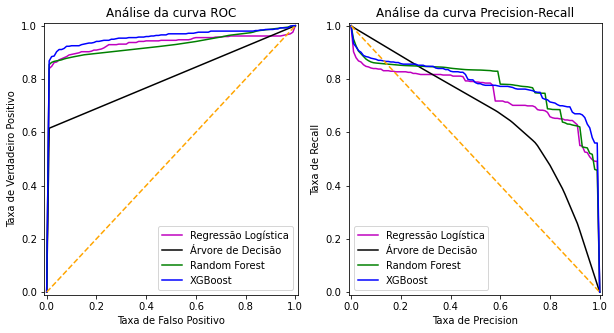

,ROC AUC,AUPRC,Precision,Recall,Time
Regressão Logística,0.790388,0.740647,0.999123,0.999115,0.722559
Árvore de Decisão,0.805421,0.670443,0.998697,0.901162,13.346881
Random Forest,0.826011,0.768089,0.999155,0.901963,145.116428
XGBoost,0.873732,0.786199,0.999327,0.999192,17.534687


In [78]:
avaliar_modelo(models_s, X, y)

[15:34:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:34:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:34:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:35:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

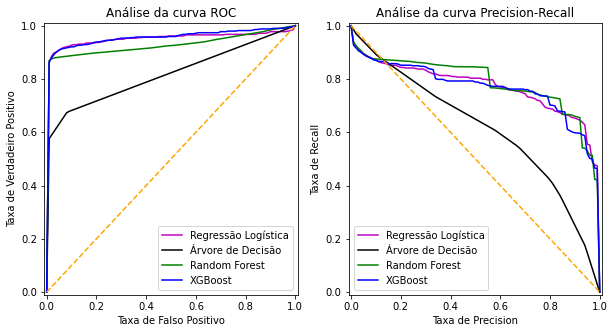

,ROC AUC,AUPRC,Precision,Recall,Time
Regressão Logística,0.927514,0.767027,0.998181,0.972992,0.702613
Árvore de Decisão,0.819368,0.613130,0.998658,0.989860,6.333758
Random Forest,0.844428,0.771375,0.999318,0.999298,78.808181
XGBoost,0.889677,0.762314,0.999168,0.998813,20.797345


In [79]:
avaliar_modelo(models, X, y)

## Até a próxima! 

![title](thank_you.png)
[Illustration by Freepik Storyset](https://storyset.com)